# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [5]:
import numpy as np
from numpy import load
import pandas as pd
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [6]:
numpyFilePath = '/content/drive/My Drive/AIML/Face_Mask_Segmentation/images.npy'
data = load(numpyFilePath,allow_pickle=True)

In [7]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [9]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
channel = 3

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [77]:
from tensorflow.keras.applications.mobilenet import preprocess_input
# from tensorflow.keras.applications.vgg16 import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_HEIGHT))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, channel))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (2 marks)

In [78]:
X_train.shape

(409, 224, 224, 3)

In [79]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


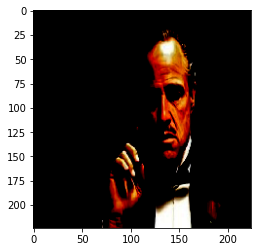

In [80]:
n = 10
# print(X_train[n])
plt.imshow(X_train[n])

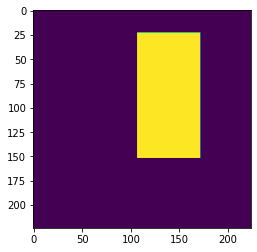

In [81]:
plt.imshow(masks[n])

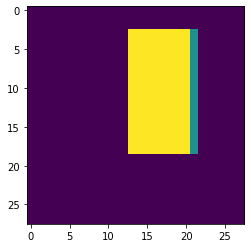

In [82]:
masks_images = np.zeros((int(data.shape[0]),28,28))
for index,img in enumerate(masks):
    img_resize = cv2.resize(img,(28,28))
#     plt.imshow(img_resize)
    masks_images[index] = img_resize
#     break

plt.imshow(masks_images[10])

In [83]:
masks_images.shape

(409, 28, 28)

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [89]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def create_model(trainable=True):
  alpha = 1.0
  basemodel = MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,channel),include_top=False,alpha=alpha,weights='imagenet')
    
  for layer in basemodel.layers:
      layer.trainable = trainable
  
  layerNames = dict([(layer.name,layer) for layer in basemodel.layers])
    #     print(layerNames['conv_pw_4_relu'])
    
  block5 = layerNames["conv_pw_5_relu"].output
  block11 = layerNames["conv_pw_11_relu"].output
  block13 = layerNames["conv_pw_13_relu"].output
    
  concatenate1 = Concatenate()([UpSampling2D()(block13), block11])
  concatenate2 = Concatenate()([UpSampling2D()(concatenate1), block5])

  x = Conv2D(1, kernel_size=1, activation="sigmoid")(concatenate2)
  x = Reshape((28, 28))(x)
    
  finalModel = Model(inputs=basemodel.input, outputs=x)
  return finalModel

In [59]:
from tensorflow.keras.applications.vgg16 import VGG16

def create_vvg16_model(trainable=True):
  basemodel = VGG16(include_top=False,input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,channel))
    
  for layer in basemodel.layers:
      layer.trainable = trainable
  
  layerNames = dict([(layer.name,layer) for layer in basemodel.layers])
    #     print(layerNames['conv_pw_4_relu'])
    
  block5 = layerNames["block3_pool"].output
  block11 = layerNames["block4_pool"].output
  block13 = layerNames["block5_pool"].output
    
  concatenate1 = Concatenate()([UpSampling2D()(block13), block11])
  concatenate2 = Concatenate()([UpSampling2D()(concatenate1), block5])

  x = Conv2D(1, kernel_size=1, activation="sigmoid")(concatenate2)
  x = Reshape((28, 28))(x)
    
  finalModel = Model(inputs=basemodel.input, outputs=x)
  return finalModel

### Call the create_model function

In [122]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
finalModel = create_model(False)

# Print summary
finalModel.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [99]:
# plot_model(finalModel,'VGG16_Unet.png')

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [125]:
from tensorflow.keras.backend import  epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

### Define loss

In [126]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log
 
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [127]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
finalModel.compile(loss=loss, optimizer=adam,metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [113]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq='epoch')
stop = EarlyStopping(monitor="loss", patience=5, mode="min",min_delta=0.01)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [128]:
finalModel.fit(X_train, masks_images ,epochs=1, batch_size=1, verbose=1,callbacks=[stop,reduce_lr,checkpoint])


405/409 [============================>.] - ETA: 0s - loss: 1.9383 - dice_coefficient: 0.2795
Epoch 00001: loss did not improve from 0.82108
409/409 [==============================] - 4s 9ms/step - loss: 1.9316 - dice_coefficient: 0.2805 - lr: 1.0000e-04


### Get the predicted mask for a sample image   (5 marks)

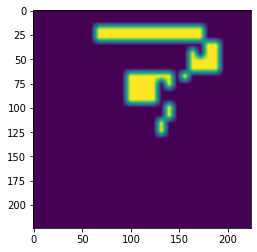

In [135]:
n = 10
sample_image = X_train[n]

img_unscale = sample_image
img = cv2.resize(img_unscale,dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
feat_img = preprocess_input(np.array(img,dtype=np.float32))
pred_mask = cv2.resize(1.0*(finalModel.predict(x=np.array([feat_img]))[0] > 0.1), (IMAGE_HEIGHT,IMAGE_WIDTH))

plt.imshow(pred_mask)

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


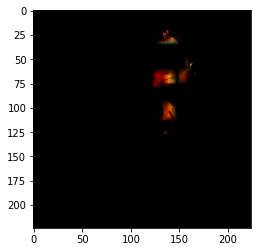

In [136]:
image2 = img
image2[:,:,0] = pred_mask*img[:,:,0]
image2[:,:,1] = pred_mask*img[:,:,1]
image2[:,:,2] = pred_mask*img[:,:,2]

out_image = image2
print(out_image.shape)
plt.imshow(out_image)

In [111]:
###